In [1]:
import os
import numpy as np
import re
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define the path to the parent directory
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Move one level up

# 1. Full phenotype

In [4]:
# Load the phenotypic data
phenotype_data_path = os.path.join(data_dir, "data/Finalset_223phenotypes_1011.csv")
phenotype_df = pd.read_csv(phenotype_data_path)

In [5]:
# Save the phenotype DataFrame to a CSV file without including the index
phenotype_output_path = os.path.join(data_dir, "data/phenotype_dataset.csv")
phenotype_df.to_csv(phenotype_output_path, index=False)
print(f"Phenotype dataset saved to {phenotype_output_path}")

Phenotype dataset saved to /Users/colineleteurtre/Library/CloudStorage/OneDrive-Personnel/Documents/cours/EPFL/machinelearning/project2/Yeast_Project/data/phenotype_dataset.csv


# 2. Choose the phenotype

In [6]:
phenotype = "YPD_doublingtime"
#phenotype = "YPDCUSO410MM_40h"

# 3. Filtered phenotype (which will later be ordered)

In [7]:
def filter_phenotype(phenotype):
    """
    Filters the phenotype dataset by removing rows with missing values for the specified phenotype column.
    
    Parameters:
        phenotype: str, the name of the phenotype column to filter on (e.g., 'YPD_doublingtime')

    Returns:
        missing_yeast_ids: list, list of Yeast_IDs with missing phenotype values
        filtered_phenotype: DataFrame, the filtered phenotype dataset without missing values for the specified phenotype
    """
    phenotype_data = pd.read_csv(os.path.join(data_dir, "data/phenotype_dataset.csv"))
    phenotype_data = phenotype_data.rename(columns={'Standard_name': 'Yeast_ID'})
    columns_of_interest = ['Yeast_ID', phenotype]
    modified_phenotype = phenotype_data[columns_of_interest]

    # Identify Yeast_IDs that have missing values for the specified phenotype
    missing_yeast_ids = modified_phenotype.loc[modified_phenotype[phenotype].isna(), "Yeast_ID"].tolist()

    # Remove rows with missing values in YPD_doublingtime
    filtered_phenotype = modified_phenotype.dropna(subset=[phenotype])
    
    return missing_yeast_ids, filtered_phenotype

missing_yeast_ids, filtered_phenotype = filter_phenotype(phenotype)

# 4. Copy number variations dataset

In [8]:
# Load the copy number variation (CNV) data from a tab-separated file
copy_number_variation_path = os.path.join(data_dir, "data/genesMatrix_CopyNumber.tab")
cnv_df = pd.read_csv(copy_number_variation_path, sep="\t", index_col=0).T
cnv_df.index.name = "Standard_name"
cnv_df.reset_index(inplace=True)

# Define the regex pattern to match the beginning of the 'Standard_name' string
pattern = r'^X\d{1,4}\.Y[A-Z]{2}\d{3}[A-Z]'

# Keep rows where 'Standard_name' matches the pattern
cnv_df = cnv_df[cnv_df['Standard_name'].str.match(pattern, na=False)]

# Reset the index after filtering rows
cnv_df = cnv_df.reset_index(drop=True)

# Define regex patterns for two specific cases in the 'Standard_name' column
pattern_case1 = r'Y[A-Z]{2}\d{3}[A-Z]'  # For case 1: "Y" + 2 uppercase letters + 3 digits + 1 uppercase letter
pattern_case2 = r'Y[A-Z]{2}\d{3}[A-Z]\.[A-Z]'  # For case 2: Same as case 1, but with ".X" at the end

# Function to extract the real name
def extract_real_name(name):
    """
    Extracts the real name of a yeast based on two specific patterns.
    
    Parameters:
        name (str): The name to be processed
    
    Returns:
        str or None: The extracted real name if it matches either pattern, or None if no match is found.
    """
    # Check if the name matches the more specific pattern (Case 2)
    match_case2 = re.search(pattern_case2, name)
    if match_case2:
        # If it matches, replace the '.' with a '-' and return the modified name
        return match_case2.group().replace('.', '-')

    # If the name doesn't match Case 2, check for Case 1 (less specific pattern)
    match_case1 = re.search(pattern_case1, name)
    if match_case1:
        # If it matches Case 1, return the name as is
        return match_case1.group()
    
    # If the name doesn't match either pattern, return None
    return None

# Apply the extract_real_name function to the 'Standard_name' column
cnv_df['Standard_name'] = cnv_df['Standard_name'].apply(extract_real_name)

# Drop rows with missing 'Standard_name' values (i.e., rows where real name extraction failed)
cnv_df = cnv_df.dropna(subset=['Standard_name']).reset_index(drop=True)

# Fill missing values in all columns (except the first one) with the median of that column
# This ensures that the columns with missing data are imputed with the central tendency (median) of the data
cnv_df.iloc[:, 1:] = cnv_df.iloc[:, 1:].fillna(cnv_df.median(numeric_only=True))

In [9]:
# Save the CNV DataFrame to a CSV file without including the index
cnv_output_path = os.path.join(data_dir, "data/copy_number_variation_dataset.csv")
cnv_df.to_csv(cnv_output_path, index=False)
print(f"Copy number variation dataset saved to {cnv_output_path}")

Copy number variation dataset saved to /Users/colineleteurtre/Library/CloudStorage/OneDrive-Personnel/Documents/cours/EPFL/machinelearning/project2/Yeast_Project/data/copy_number_variation_dataset.csv


# 5. Mutations of each yeast on each protein dataset

In [ ]:
proteome_dir_path = os.path.join(data_dir, "data/Proteome_1011")  # Dossier contenant les fichiers de séquences protéiques

# List to store mutation data
mutations = []

# Iterate over each file in the protein folder
for filename in os.listdir(proteome_dir_path):
    if filename.endswith(".fasta"):
        filepath = os.path.join(proteome_dir_path, filename)
        protein_id = filename.split(".")[0]                 # Extract the protein ID from the filename
        
        # Initialize a dictionary to store sequences by yeast ID
        sequences = {}
        with open(filepath, "r") as file:
            current_yeast = None
            # Read the file line by line
            for line in file:
                if line.startswith(">"):                    # Line starts with '>', indicating a new yeast sequence
                    header = line.strip().split()[0][1:]    # Extract yeast identifier (remove '>')
                    # Extract the yeast ID before the protein name in the header
                    current_yeast = header.split(f"_{protein_id}", 1)[0]    
                    sequences[current_yeast] = ""           # Initialize an empty sequence for the yeast
                else:
                    sequences[current_yeast] += line.strip()    # Add the amino acids for the yeast
        
        # Transpose the sequences to analyze position by position
        yeast_ids = list(sequences.keys())                  # List of yeast IDs
        transposed_positions = zip(*sequences.values())     # Transpose the sequences: columns become rows
        
        # Identify mutations by comparing each amino acid to the most common amino acid at that position
        for idx, amino_acids in enumerate(transposed_positions, start=1):
            aa_counts = Counter(amino_acids)                # Count occurrences of each amino acid at this position
            most_common_aa, _ = aa_counts.most_common(1)[0]     # Get the most common amino acid
            
            # Check for mutations: If the amino acid is different from the most common one
            for yeast_id, aa in zip(yeast_ids, amino_acids):
                if aa != most_common_aa:  # Mutation detected
                    # Append the mutation data to the list
                    mutations.append({
                        "Protein_ID": protein_id,
                        "Yeast_ID": yeast_id,
                        "Position": idx,
                        "Reference_AA": most_common_aa,
                        "Mutated_AA": aa
                    })

# Convert the mutations list into a pandas DataFrame
mutations_df = pd.DataFrame(mutations)

In [ ]:
# Save the mutations DataFrame to a CSV file without including the index
mutations_output_path = os.path.join(data_dir, "data/mutations_dataset.csv")
mutations_df.to_csv(mutations_output_path, index=False)
print(f"Mutations dataset saved to {mutations_output_path}")

# 6. Extended mutation matrix

In [10]:
def create_mutation_matrix(df, min_mutations=2):
    """
    Creates a mutation matrix where each row corresponds to a yeast, and each column corresponds to a specific mutation.
    Mutations with fewer occurrences than `min_mutations` are filtered out.
    
    Parameters:
    - df: DataFrame containing mutation data (Yeast_ID, Protein_ID, Position, Reference_AA, Mutated_AA).
    - min_mutations: Minimum number of occurrences a mutation must have to be included in the matrix.
    
    Returns:
    - A DataFrame representing the mutation matrix, with Yeast_ID as rows and Mutation_Label as columns.
    """
    # Filter out rows where Yeast_IDs are in the missing_yeast_ids list
    # The .copy() is used to avoid pandas SettingWithCopyWarning
    df = df[~df['Yeast_ID'].isin(missing_yeast_ids)].copy()

    # Create a Mutation_Label column that combines Protein_ID, Position, Reference_AA, and Mutated_AA
    df.loc[:, 'Mutation_Label'] = (
        df['Protein_ID'] + '_' +
        df['Position'].astype(str) + '_' +
        df['Reference_AA'] + '->' + df['Mutated_AA']
    )

    # Drop duplicates to ensure each mutation appears only once per yeast
    df = df.drop_duplicates(subset=['Yeast_ID', 'Mutation_Label'])
    
    # Pivot the data to create a matrix where Yeast_ID is the index and Mutation_Label is the columns
    mutation_matrix = df.pivot(index='Yeast_ID', 
                               columns='Mutation_Label', 
                               values='Mutation_Label')
    
    # Fill missing values with 0 and indicate presence of mutation with 1
    mutation_matrix = mutation_matrix.notnull().astype(int)
    
    # Print the number of mutations (columns) before filtering
    num_mutations_before = mutation_matrix.shape[1]
    print(f"Number of mutations before filtering: {num_mutations_before}")
    
    # Filter out columns (mutations) with fewer than `min_mutations` occurrences across yeasts
    mutation_matrix = mutation_matrix.loc[:, (mutation_matrix.sum(axis=0) >= min_mutations)]
    
    # Print the number of mutations (columns) after filtering
    num_mutations_after = mutation_matrix.shape[1]
    print(f"Number of mutations after filtering: {num_mutations_after}")
    
    # Reset the index to include Yeast_ID as a column in the resulting matrix
    mutation_matrix.reset_index(inplace=True)
    
    return mutation_matrix

# Define a dictionary to specify the expected data types for each column in the mutations dataset
dtype_dict = {
    'Yeast_ID': str,          # Yeast_ID might be a string
    'Protein_ID': str,        # Protein_ID might be a string
    'Position': str,          # Position might be a string
    'Reference_AA': str,      # Reference_AA might be a string
    'Mutated_AA': str,        # Mutated_AA might be a string
}

# Load the mutation data from a CSV file
mutations_data = pd.read_csv(os.path.join(data_dir, "data/mutations_dataset.csv"), dtype=dtype_dict)

# Create the mutation matrix from the mutation data
mutation_matrix = create_mutation_matrix(mutations_data)

Number of mutations before filtering: 537120
Number of mutations after filtering: 341901


In [11]:
# Save the extended_mutations DataFrame to a CSV file without including the index
extended_mutations_output_path = os.path.join(data_dir, f"data/extended_mutations_{phenotype}.csv")
mutation_matrix.to_csv(extended_mutations_output_path, index=False)
print(f"Extended mutations dataset saved to {extended_mutations_output_path}")

Extended mutations dataset saved to /Users/colineleteurtre/Library/CloudStorage/OneDrive-Personnel/Documents/cours/EPFL/machinelearning/project2/Yeast_Project/data/extended_mutations_YPD_doublingtime.csv


# 7. X matrix

In [12]:
# File paths
cnv_path = os.path.join(data_dir, "data/copy_number_variation_dataset.csv")

# Step 1: Load necessary files
print("Step 1: Loading CNV data with Pandas....")
cnv_data = pd.read_csv(cnv_path)
print("CNV data loaded successfully.")

# Step 2: Use the in-memory mutation matrix to save time
print("Using the in-memory mutation matrix...")
# mutation_matrix = pd.read_csv(os.path.join(data_dir, f"data/extend_mutations_{phenotype}.csv"))

# Step 3: Identify unique proteins in the mutation matrix
print("Step 3: Identifying unique proteins in the mutation matrix...")
mutation_column_names = mutation_matrix.columns[1:]  # Exclude the 'Yeast_ID' column
protein_columns = [col.split('_')[0] for col in mutation_column_names]
unique_proteins = set(protein_columns)
print(f"Number of proteins with mutations: {len(unique_proteins)}")

# Step 4: Transpose the filtered CNV data
print("Step 4: Transposing CNV data...")
print(f"Number of CNV proteins: {cnv_data.shape[0]}")
filtered_cnv_transposed = cnv_data.set_index('Standard_name').transpose()
print("CNV transposition complete.")

# Step 5: Merge mutation_matrix and filtered_cnv_transposed
print("Step 5: Merging mutation and CNV matrices...")
X_matrix = mutation_matrix.merge(
    filtered_cnv_transposed, 
    left_on='Yeast_ID', 
    right_index=True, 
    how='left'
)
print(f"Merging complete. Dimensions of X_matrix: {X_matrix.shape}")

Step 1: Loading CNV data with Pandas....
CNV data loaded successfully.
Using the in-memory mutation matrix...
Step 3: Identifying unique proteins in the mutation matrix...
Number of proteins with mutations: 6467
Step 4: Transposing CNV data...
Number of CNV proteins: 6051
CNV transposition complete.
Step 5: Merging mutation and CNV matrices...
Merging complete. Dimensions of X_matrix: (792, 347953)


Saving to a pickle file.

In [13]:
# Save the X_matrix DataFrame to a pickle file
X_matrix_output_path = os.path.join(data_dir, f"data/X_matrix_{phenotype}.pkl")
X_matrix.to_pickle(X_matrix_output_path)
print(f"Combined matrix X saved to {X_matrix_output_path}")

Combined matrix X saved to /Users/colineleteurtre/Library/CloudStorage/OneDrive-Personnel/Documents/cours/EPFL/machinelearning/project2/Yeast_Project/data/X_matrix_YPD_doublingtime.pkl


Saving to a CSV file.

In [ ]:
# Save the X_matrix DataFrame to a CSV file without including the index 
X_matrix_output_path = os.path.join(data_dir, f"data/X_matrix_{phenotype}.csv")
X_matrix.to_csv(X_matrix_output_path, index=False)
print(f"Combined matrix X saved to {X_matrix_output_path}")

Combined matrix X saved to data/X_matrix_YPDCUSO410MM_40h.csv


# 8. y phenotype

In [14]:
# Order the phenotype
y_phenotype = filtered_phenotype.set_index('Yeast_ID').reindex(X_matrix['Yeast_ID']).reset_index()

Saving to a Pickle file.

In [15]:
# Save the y_phenotype DataFrame to a pickle file 
y_phenotype_output_path = os.path.join(data_dir, f"data/y_{phenotype}.pkl")
y_phenotype.to_pickle(y_phenotype_output_path)
print(f"Ordered phenotype saved to {y_phenotype_output_path}")

Ordered phenotype saved to /Users/colineleteurtre/Library/CloudStorage/OneDrive-Personnel/Documents/cours/EPFL/machinelearning/project2/Yeast_Project/data/y_YPD_doublingtime.pkl


Saving to a CSV file.

In [16]:
# Save the y_phenotype DataFrame to a CSV file without including the index 
y_phenotype_output_path = os.path.join(data_dir, f"data/y_{phenotype}.csv")
y_phenotype.to_csv(y_phenotype_output_path, index=False)
print(f"Ordered phenotype saved to {y_phenotype_output_path}")

Ordered phenotype saved to /Users/colineleteurtre/Library/CloudStorage/OneDrive-Personnel/Documents/cours/EPFL/machinelearning/project2/Yeast_Project/data/y_YPD_doublingtime.csv


# 9. Plots

## 9.a y phenotype distribution

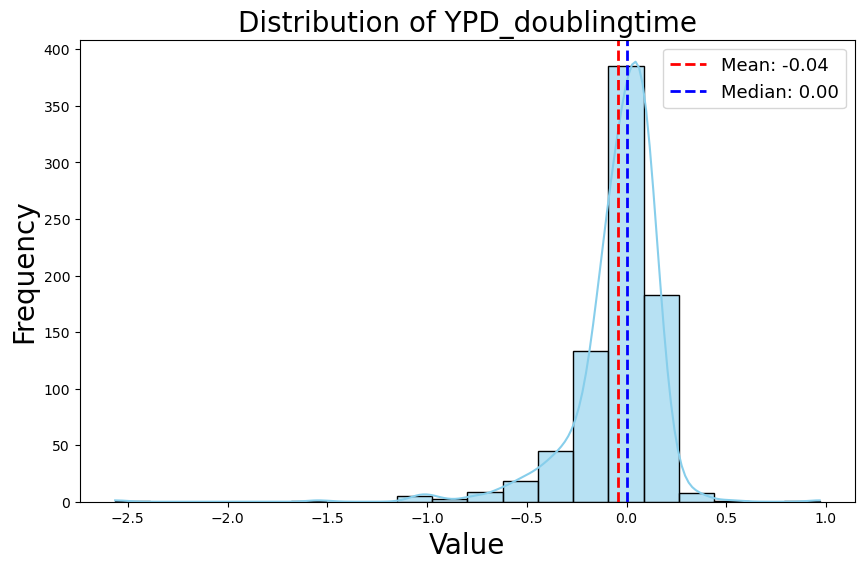

In [22]:
# Prepare data
y_data = y_phenotype.drop(columns=["Yeast_ID"])

# Median value
median_value = y_data[phenotype].median()

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot histogram for the single column with KDE
sns.histplot(y_data[phenotype], kde=True, bins=20, color='skyblue', alpha=0.6)

# Calculate mean and median
mean_val = y_data[phenotype].mean()
median_val = y_data[phenotype].median()

# Plot lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')

# Add title and labels
plt.title(f'Distribution of {phenotype}', fontsize=20)
plt.xlabel('Value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

# Add legend
plt.legend(fontsize=13)

# Save the plot to a file (e.g., as a PNG file)
plt.savefig(os.path.join(data_dir, f'results/plots/y_{phenotype}.png'), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## 9.b Extended mutations matrix distribution

In [23]:
# Prepare the dataset from X_matrix
X_file = os.path.join(data_dir, f"data/X_matrix_{phenotype}.csv")

# Load the column names (header)
column_names = np.genfromtxt(X_file, delimiter=',', max_rows=1, dtype=str)[1:]  # Skip the first column if it's row names

# Read the first line of the file to determine the number of columns
with open(X_file, 'r') as f:
    first_line = f.readline()
    end_column_index = len(first_line.split(','))  # Count the number of columns in the first line

# Load the row names (index) from the first column and the data (excluding first column)
data = np.loadtxt(X_file, delimiter=',', skiprows=1, usecols=range(1, end_column_index))
row_names = np.loadtxt(X_file, delimiter=',', skiprows=1, usecols=0, dtype=str)

# Create the DataFrame
X_data = pd.DataFrame(data, index=row_names, columns=column_names)


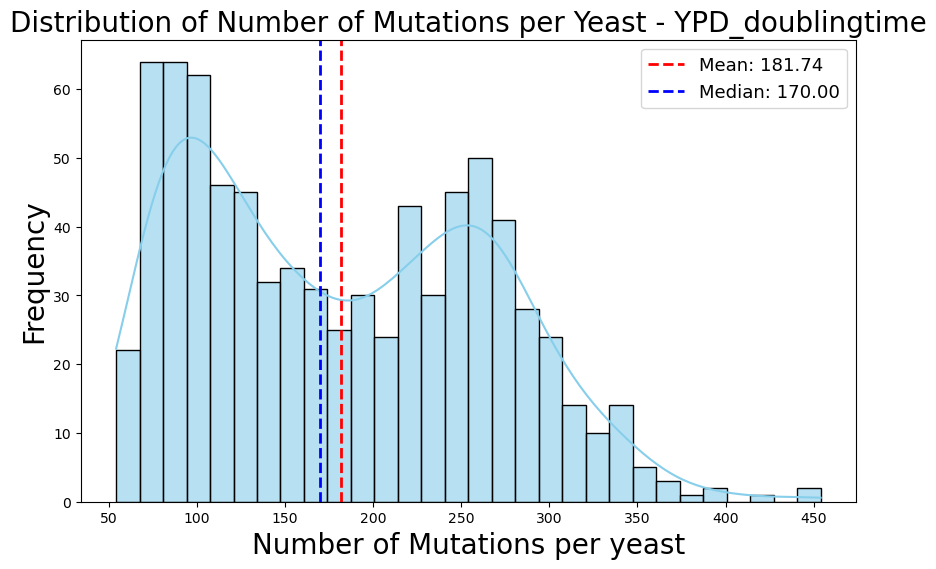

In [24]:
# Prepare the dataset
cnv_data = pd.read_csv(os.path.join(data_dir, f"data/copy_number_variation_dataset.csv"))
num_last_columns = cnv_data.shape[0]

# Calculate the number of mutations per yeast (i.e., sum across each row)
mutation_counts = X_data.iloc[:, :num_last_columns].sum(axis=1)

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot the distribution using Seaborn
sns.histplot(mutation_counts, kde=True, bins=30, color='skyblue', alpha=0.6)

# Calculate mean and median
mean_val = mutation_counts.mean()
median_val = mutation_counts.median()

# Plot lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')

# Add title and labels
plt.title(f'Distribution of Number of Mutations per Yeast - {phenotype}', fontsize=20)
plt.xlabel('Number of Mutations per yeast', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

# Add legend
plt.legend(fontsize=13)

# Save the plot to a file (e.g., as a PNG file)
plt.savefig(os.path.join(data_dir, f'results/plots/mutation_per_yeast_{phenotype}.png'), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

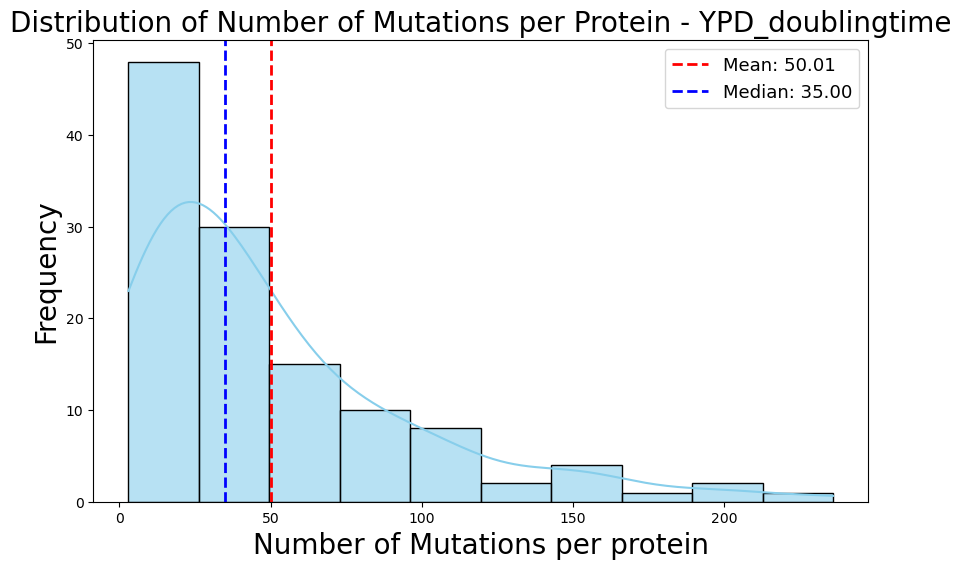

In [25]:
# Step 1: Extract protein names from the DataFrame's column names (keys)
proteins = [col.split('_')[0] for col in X_data.iloc[:, :num_last_columns].columns]

# Step 2: Count how many mutations are associated with each protein
mutation_counts = Counter(proteins)

# Step 3: Convert the mutation counts into a pandas DataFrame for easy plotting
mutation_df = pd.DataFrame(list(mutation_counts.items()), columns=['Protein', 'Mutation Count'])

# Step 4: Plot the distribution of the number of mutations per protein
plt.figure(figsize=(10, 6))
sns.histplot(mutation_df['Mutation Count'], kde=True, bins=10, color='skyblue', alpha=0.6)

# Calculate mean and median
mean_val = mutation_df['Mutation Count'].mean()
median_val = mutation_df['Mutation Count'].median()

# Plot lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')

# Add title and labels
plt.title(f'Distribution of Number of Mutations per Protein - {phenotype}', fontsize=20)
plt.xlabel('Number of Mutations per protein', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

# Add legend
plt.legend(fontsize=13)

# Save the plot to a file (e.g., as a PNG file)
plt.savefig(os.path.join(data_dir, f'results/plots/mutation_per_protein_{phenotype}.png'), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## 9.c CNV data

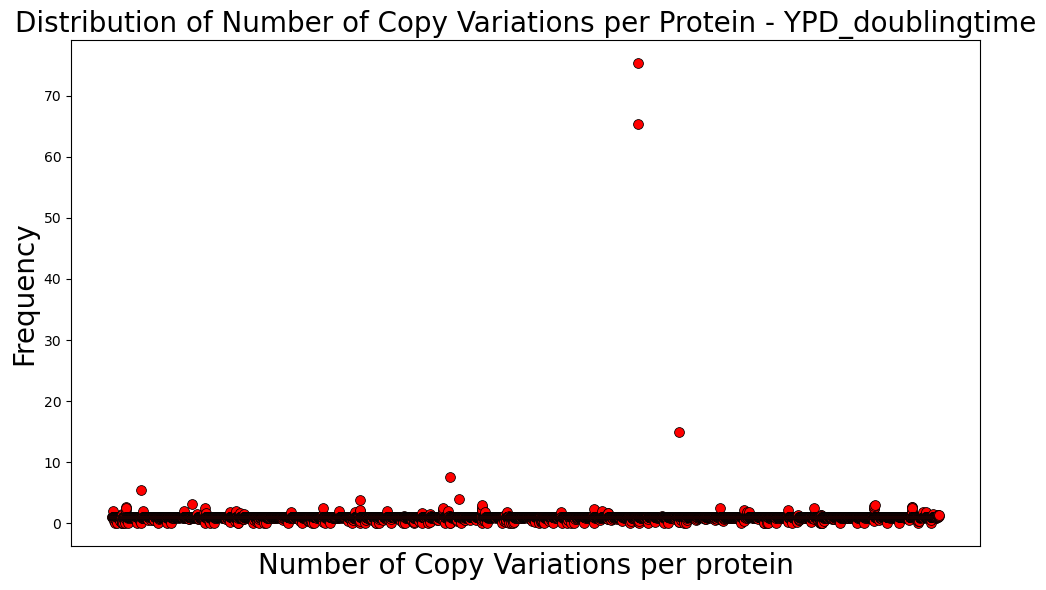

In [26]:
# Step 1: Select the CNV columns
cnv_data = pd.read_csv(os.path.join(data_dir, f"data/copy_number_variation_dataset.csv"))
num_last_columns = cnv_data.shape[0]
target_columns = X_data.iloc[:, -num_last_columns:]

# Step 2: Compute the mean number of copy variations for each protein
protein_mean_variations = target_columns.mean(axis=0)  # Compute the mean for each protein (column)

# Step 3: Create a histogram for the distribution of copy variations
plt.figure(figsize=(10, 6))

# Scatter plot: We use scatterplot to plot the count of mutations for each protein
sns.scatterplot(x=protein_mean_variations.index, y=protein_mean_variations.values, color='red', s=50, edgecolor='black')

# Calculate mean and median
mean_val = protein_mean_variations.mean()
median_val = protein_mean_variations.median()

# Set the x-axis limits to avoid unnecessary space
plt.xticks(rotation=45, ha='right')

# Add titles and labels
plt.title(f'Distribution of Number of Copy Variations per Protein - {phenotype}', fontsize=20)
plt.xlabel('Number of Copy Variations per protein', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

# Remove x-axis labels
plt.xticks([])

# Show the plot
plt.tight_layout()

# Save the plot to a file (e.g., as a PNG file)
plt.savefig(os.path.join(data_dir, f'results/plots/CNV_per_protein_{phenotype}.png'), dpi=300, bbox_inches='tight')

plt.show()

